Data Science Revealed by Tshepo Chris Nokeri, Apress. 2021

# Chapter 2: Forecasting using ARIMA, SARIMA and Additive Model

Time series analysis is a method for explaining sequential problems. It is convenient when a continuous variable is time-dependent. In finance, we frequently use it to discover consistent patterns in the market data and forecast future prices.

This chapter enables readers to design, develop and test time series analysis models like the Autoregressive Integrated Moving Average (ARIMA) model, Seasonal Autoregressive Integrated Moving Average (SARIMA) model, and Additive model, to identify patterns in currency pairs and forecast future prices. 

# Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("talk","ticks",font_scale=1,font="Calibri")
from pylab import rcParams
plt.rcParams["figure.dpi"] = 300
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas_datareader import data
start_date = '2010-11-01'
end_date = '2020-11-01'
ticker = 'AMZN'
df = data.get_data_yahoo(ticker, start_date, end_date)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-11-01,81.111000,80.320000,80.572998,80.405998,0.0,80.405998
2010-11-02,80.936996,80.480003,80.510002,80.558998,0.0,80.558998
2010-11-03,81.467003,80.589996,80.655998,80.667999,0.0,80.667999
2010-11-04,81.199997,80.587997,81.057999,81.050003,0.0,81.050003
2010-11-05,81.430000,80.619003,80.769997,80.776001,0.0,80.776001


## Data Preprocessing

In [2]:
del df["Open"]
del df["High"]
del df["Low"]
del df["Close"]
del df["Volume"]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2606 entries, 2010-11-01 to 2020-11-02
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2606 non-null   float64
dtypes: float64(1)
memory usage: 40.7 KB


In [3]:
df.index

DatetimeIndex(['2010-11-01', '2010-11-02', '2010-11-03', '2010-11-04',
               '2010-11-05', '2010-11-08', '2010-11-09', '2010-11-10',
               '2010-11-11', '2010-11-12',
               ...
               '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
               '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29',
               '2020-10-30', '2020-11-02'],
              dtype='datetime64[ns]', name='Date', length=2606, freq=None)

## Splitting Data

In [4]:
train = df[:2085]
test = df[2085:]

# Test for Stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller
adfullerreport = adfuller(train["Adj Close"])
adfullerreportdata = pd.DataFrame(adfullerreport[0:4],
                                  columns = ["Values"],
                                  index=["ADF F% statistics",
                                         "P-value",
                                         "No. of lags used",
                                         "No. of observations"])
adfullerreportdata

,Values
ADF F% statistics,-1.267857
P-value,0.643747
No. of lags used,6.000000
No. of observations,2078.000000


# Test for White Noise

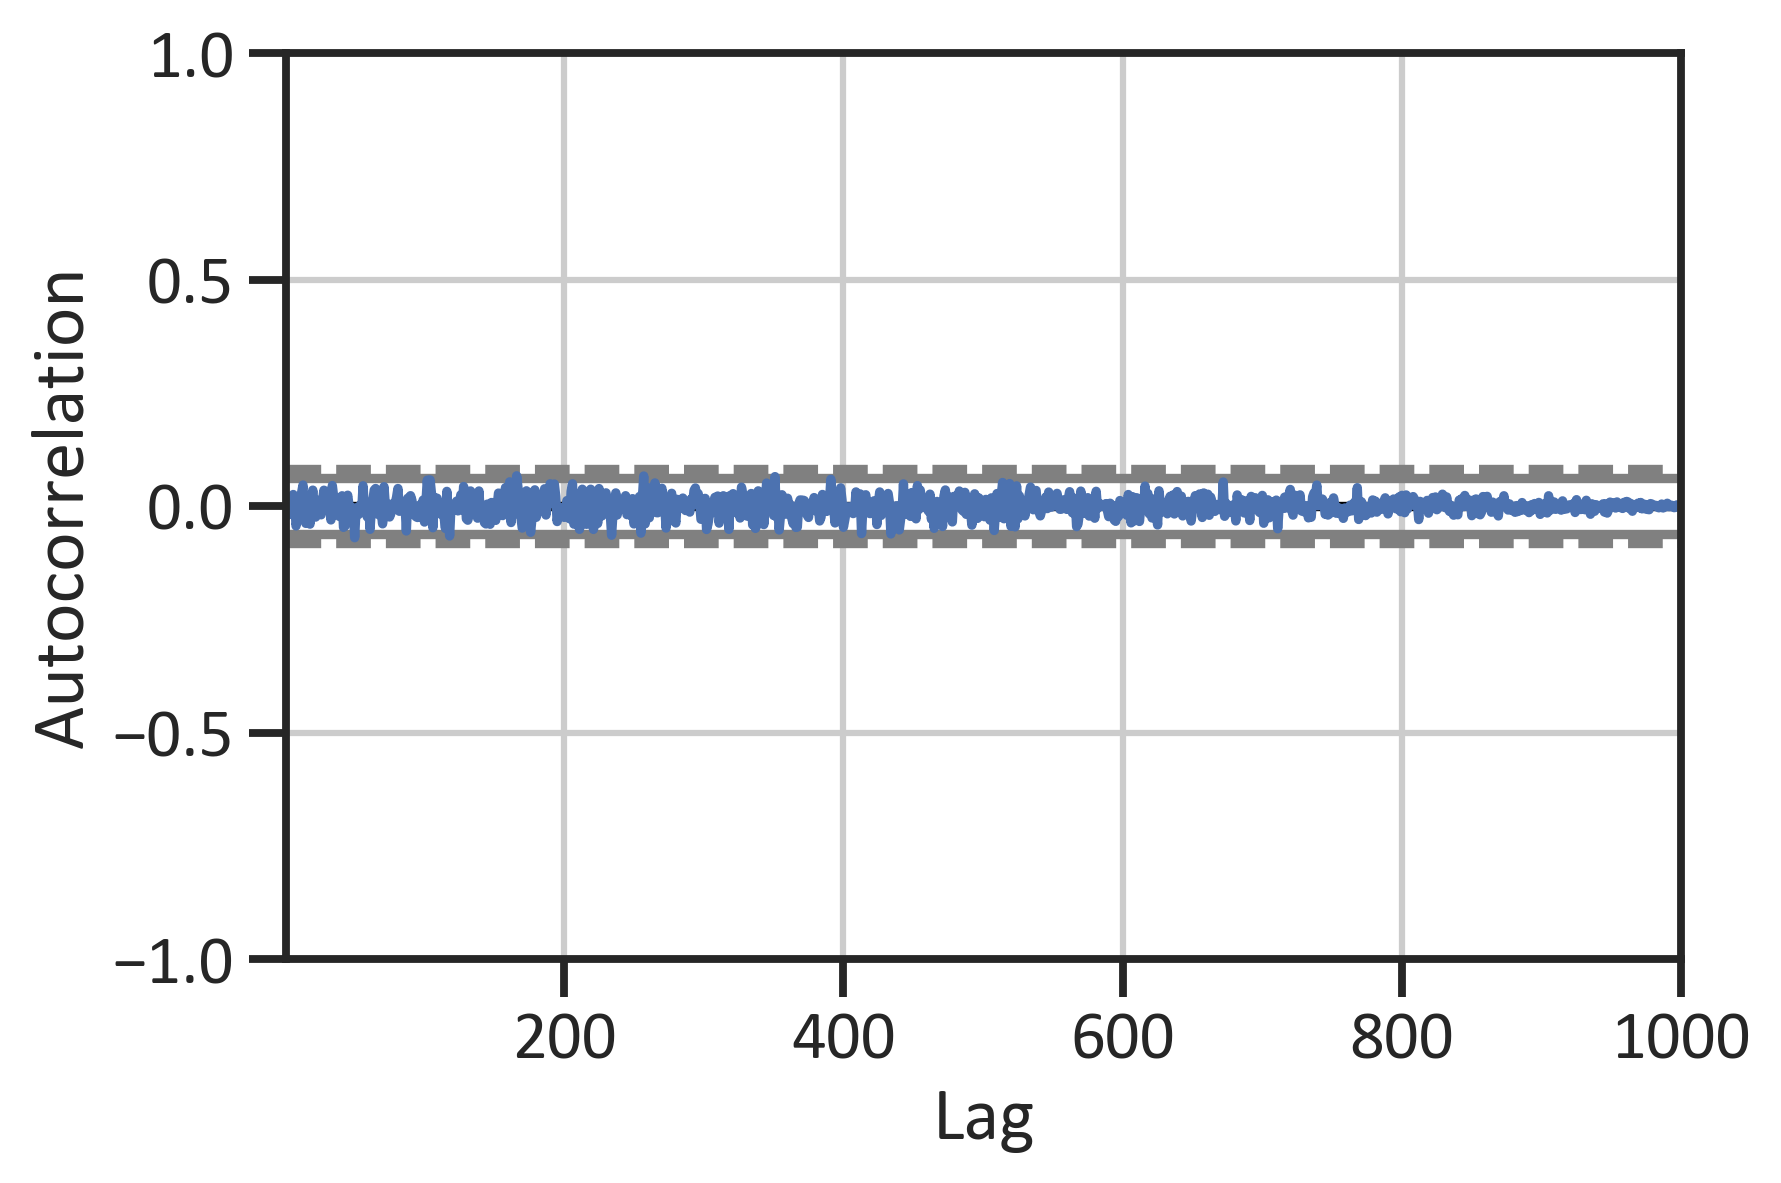

In [6]:
randval = np.random.randn(1000)
autocorrelation_plot(randval)
plt.show()

## Test for Autocorrelation

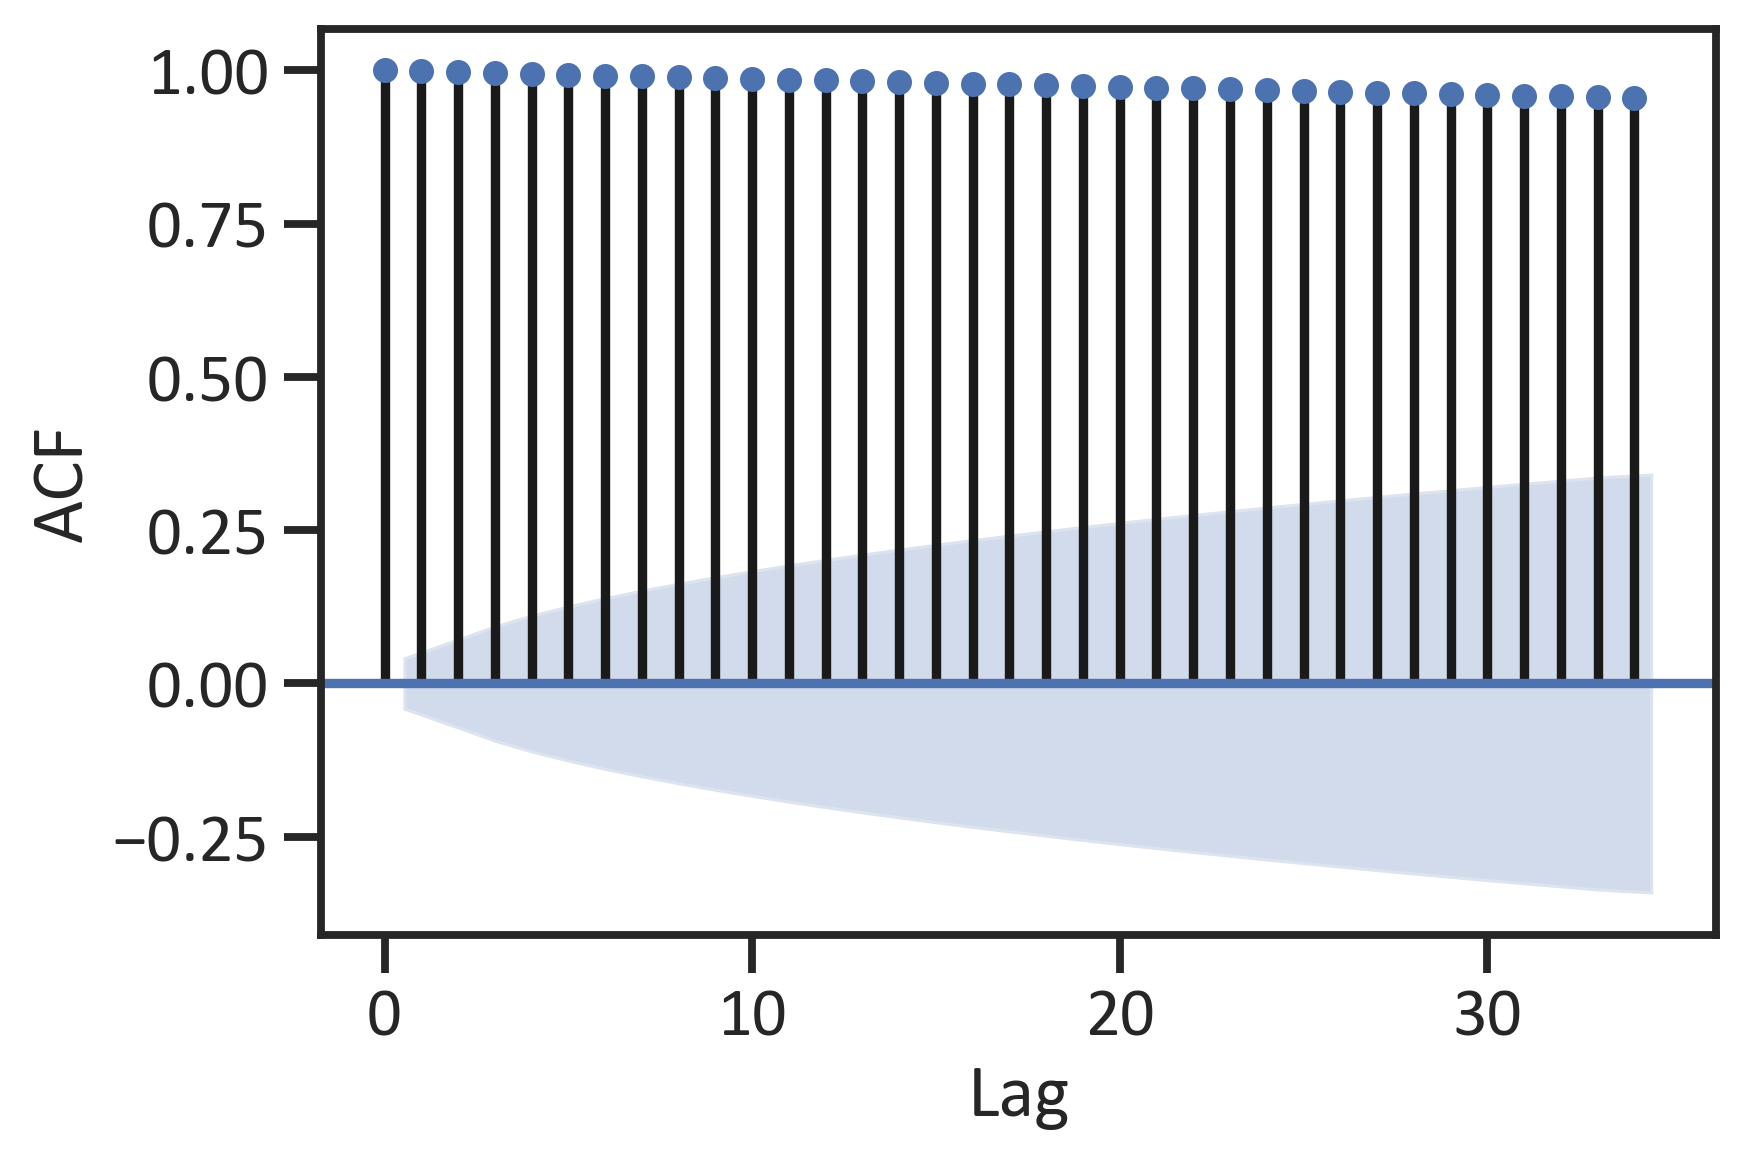

<function matplotlib.pyplot.show(*args, **kw)>

In [7]:
plot_acf(train["Adj Close"])
plt.title("")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()
plt.show

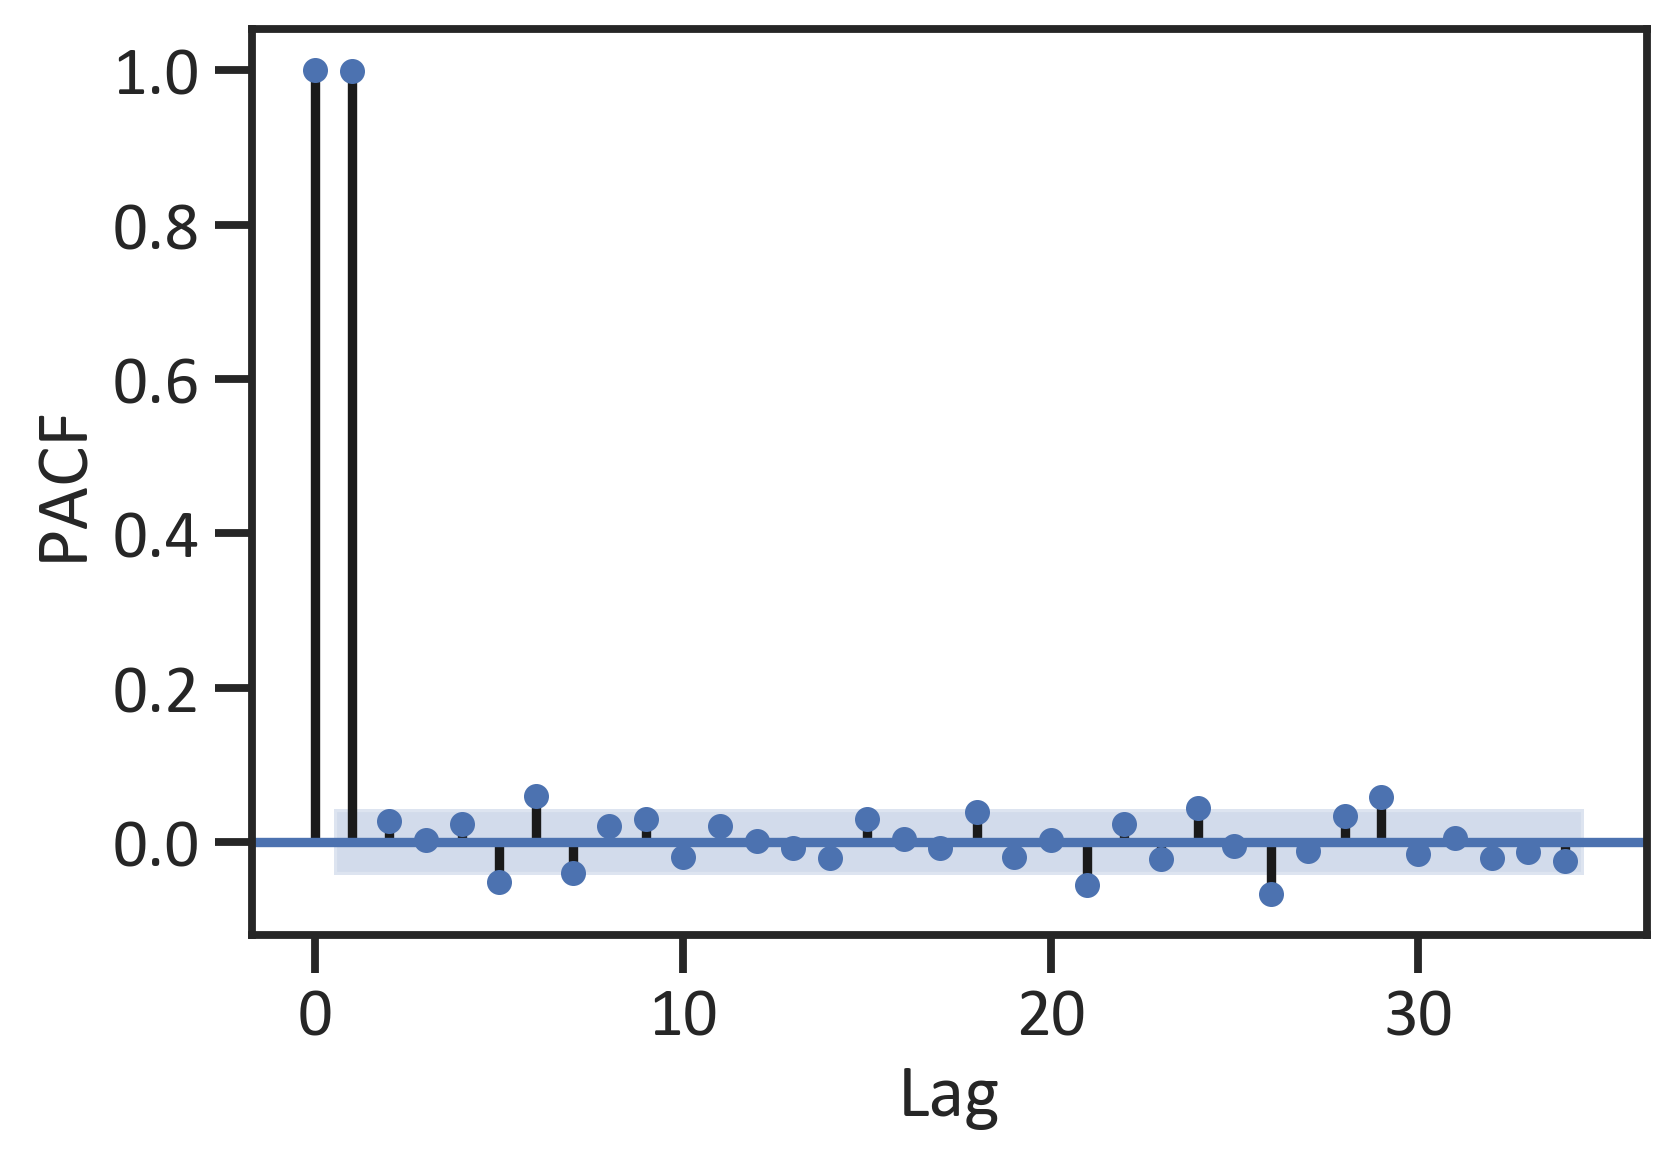

In [8]:
plot_pacf(train["Adj Close"])
plt.title("")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.show()


# 10-day and 50-day MA Smoothening

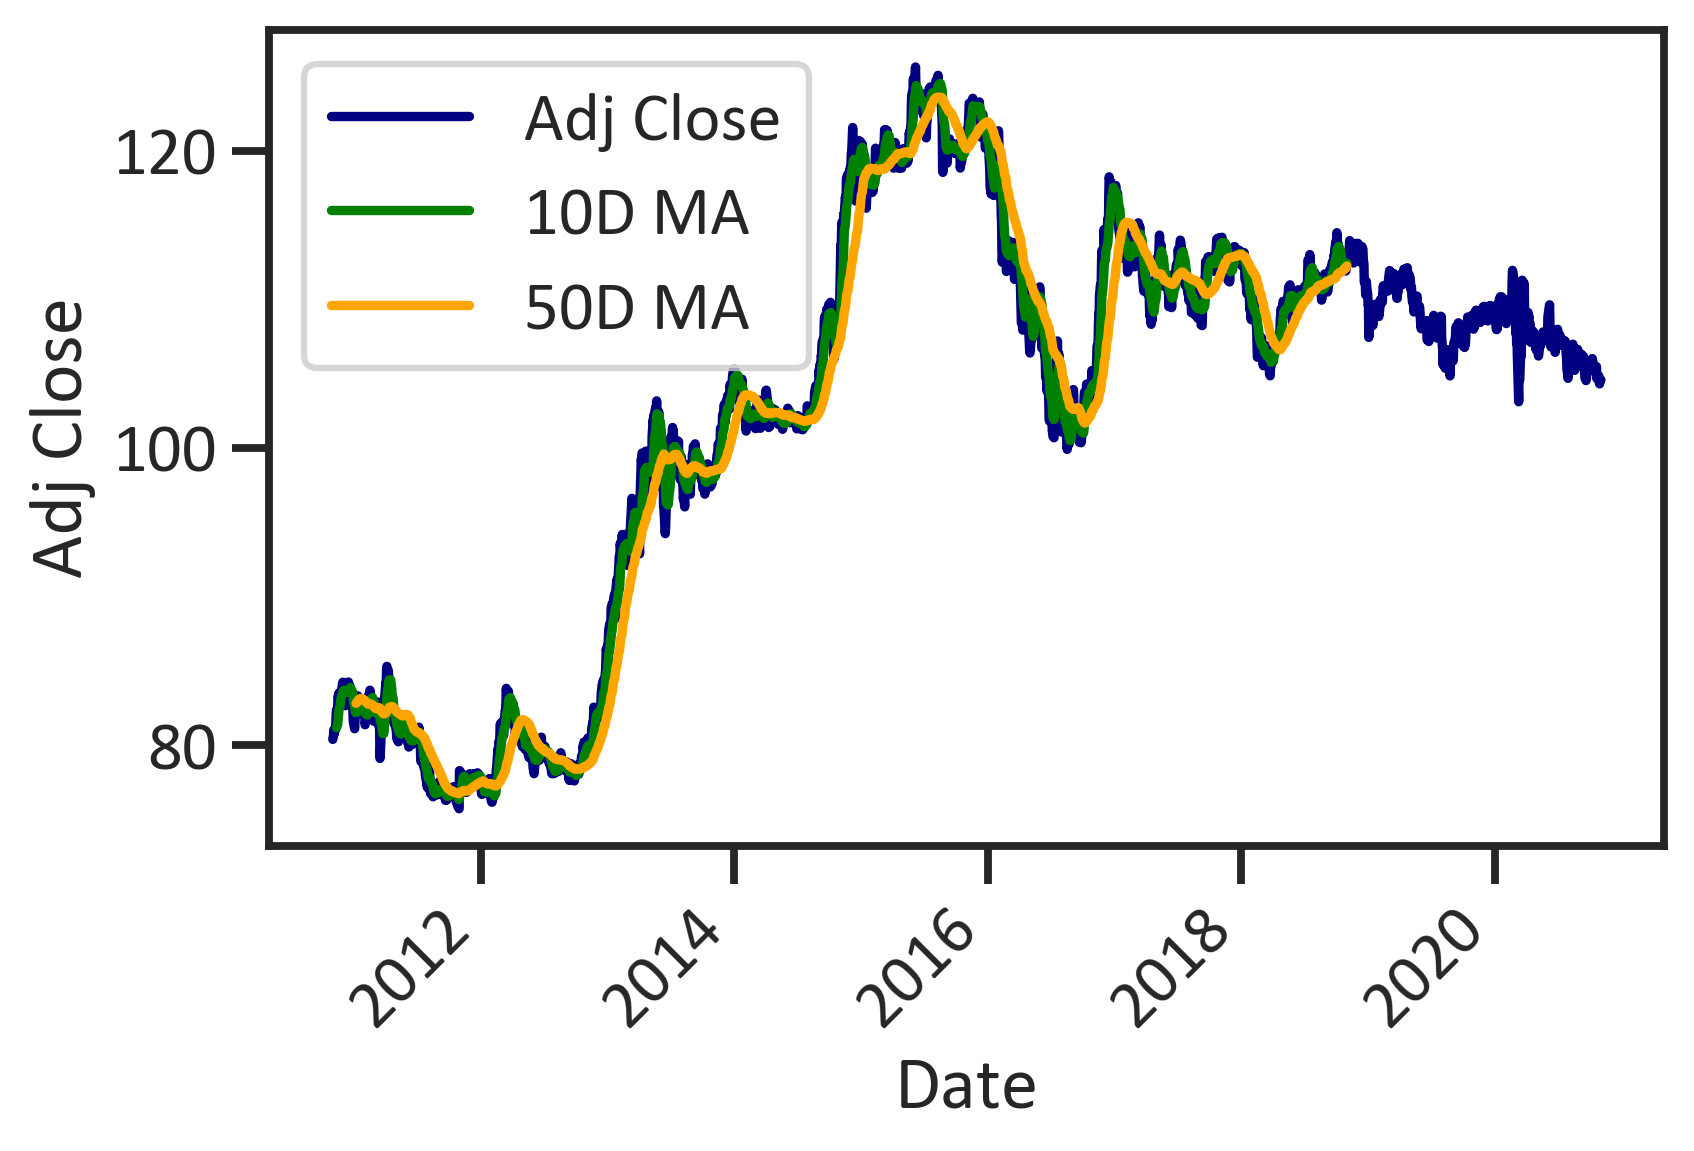

In [9]:
MA10 = train["Adj Close"].rolling(window=10).mean()
MA50 = train["Adj Close"].rolling(window=50).mean()
df.plot(kind="line",color="navy")
MA10.plot(kind="line",color="green",label="10D MA")
MA50.plot(kind="line",color="orange",label="50D MA")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Adj Close")
plt.legend()
plt.show()

# Exponential Smoothening

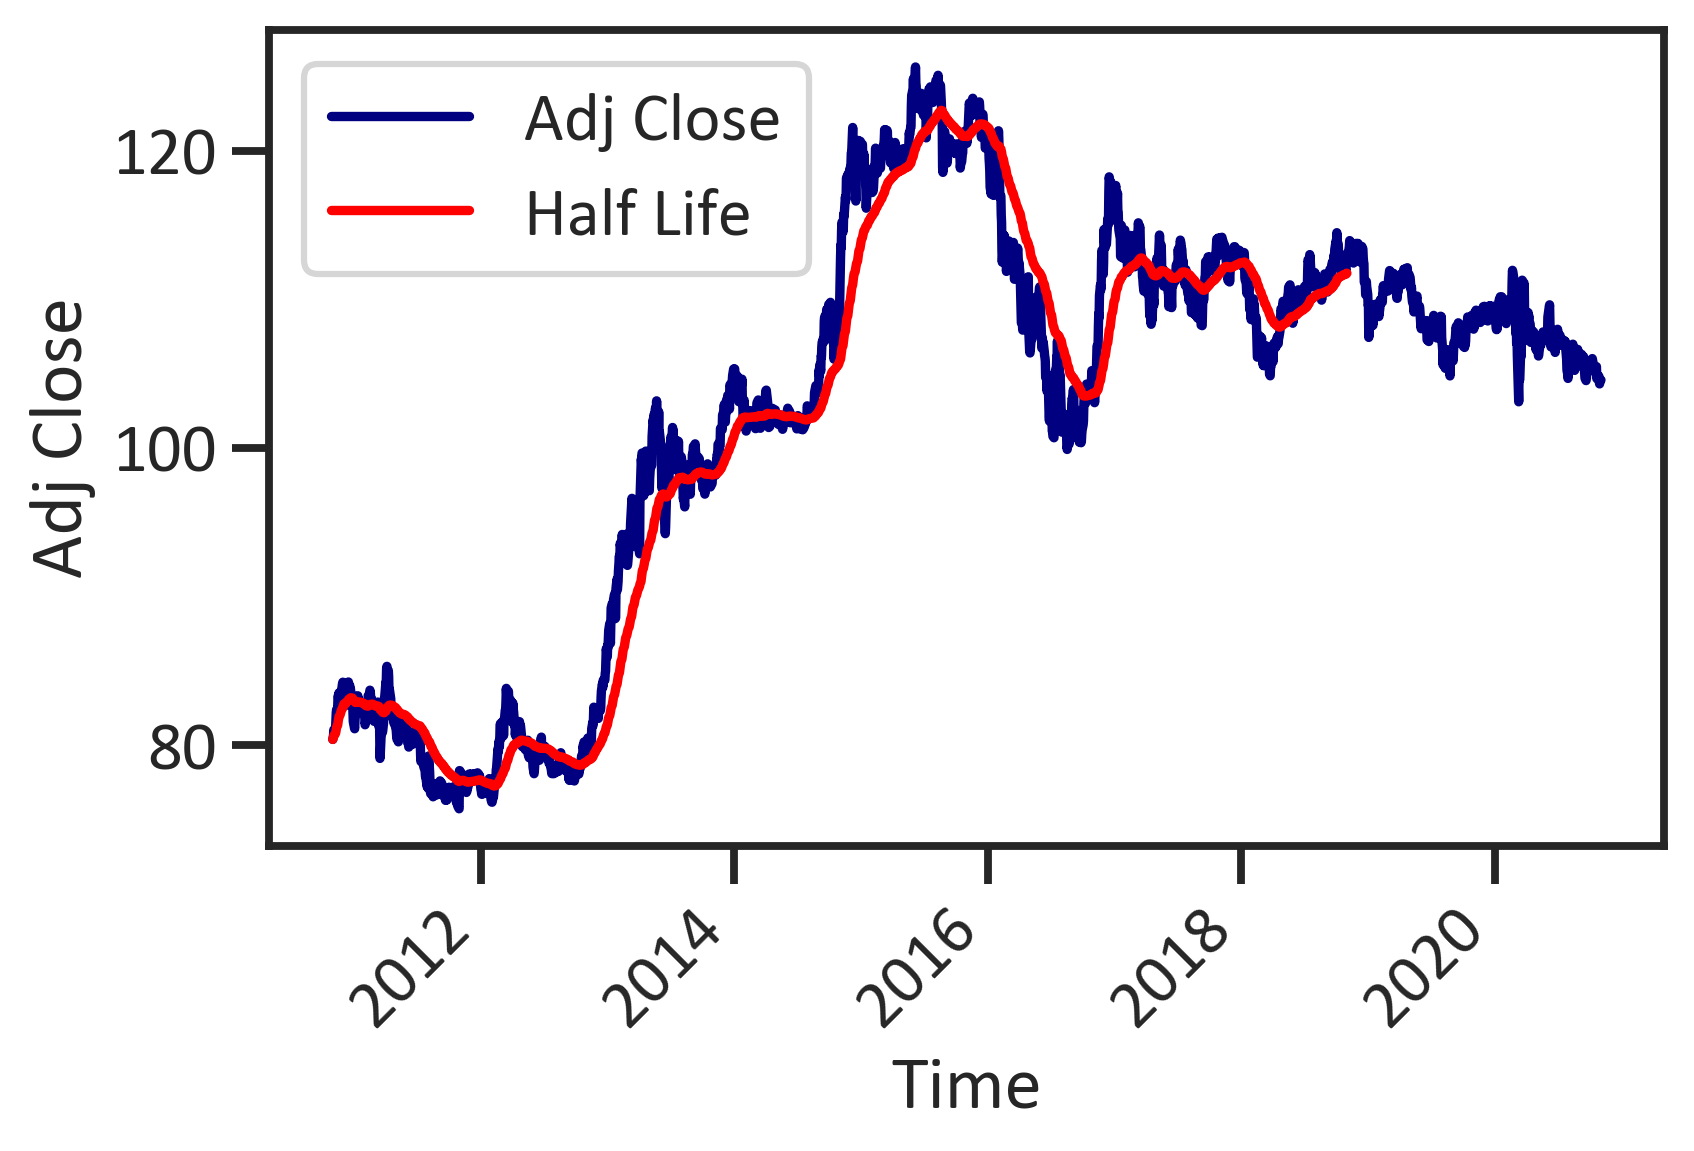

In [10]:
Exp = train["Adj Close"].ewm(halflife=30).mean()
df.plot(kind="line", color="navy")
Exp.plot(kind="line", color="red", label="Half Life")
plt.xlabel("Time")
plt.ylabel("Adj Close")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Cumulative Return

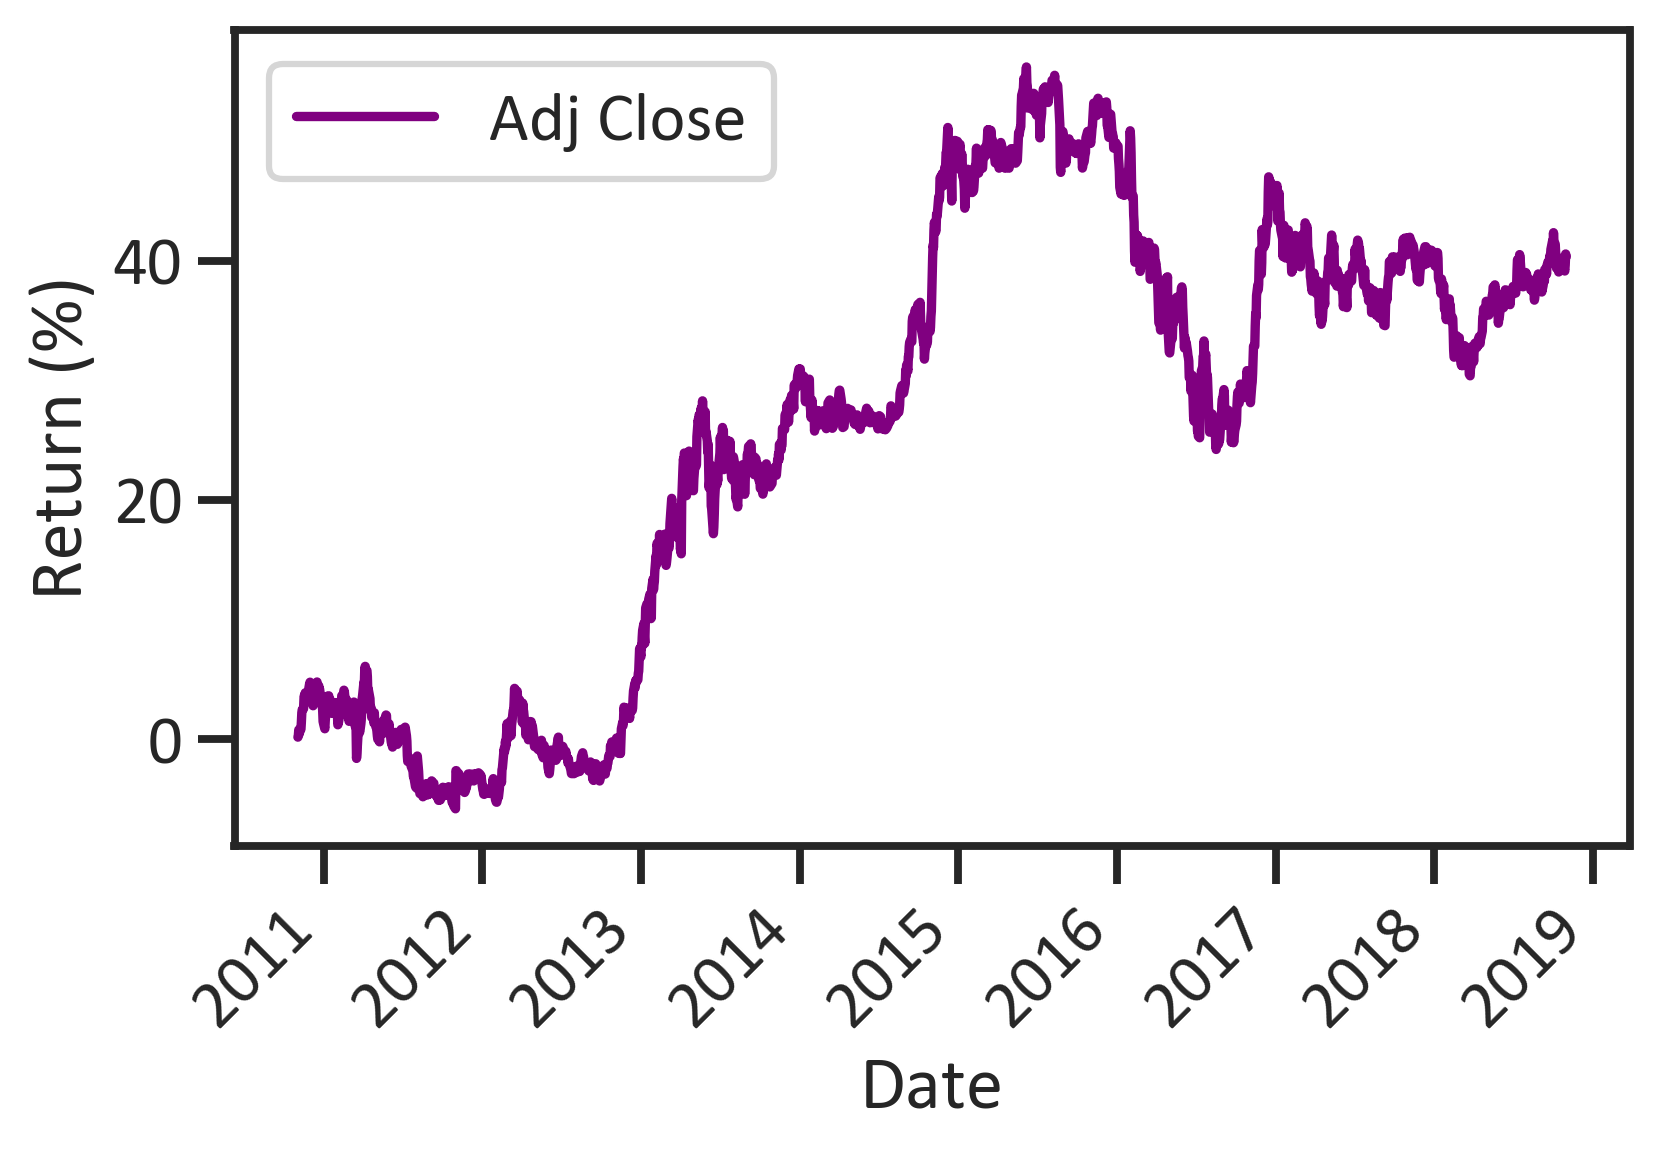

In [11]:
pr = train.pct_change()
pr_plus_one = pr.add(1)
cumulative_return = pr_plus_one.cumprod().sub(1)
fig, ax = plt.subplots()
cumulative_return.mul(100).plot(ax=ax, color="purple")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.xticks(rotation=45)
plt.show()

# Develop ARIMA Model

In [12]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [13]:
for param in pdq:
    mod = ARIMA(train, order=param)
    results = mod.fit()
    print('ARIMA{} AIC:{}'.format(param, results.aic))

ARIMA(0, 0, 0) AIC:17153.28608377512
ARIMA(0, 0, 1) AIC:14407.085213632363
ARIMA(0, 1, 0) AIC:3812.4806641861296
ARIMA(0, 1, 1) AIC:3812.306176824848
ARIMA(1, 0, 0) AIC:3823.4611095477635
ARIMA(1, 0, 1) AIC:3823.432441560404
ARIMA(1, 1, 0) AIC:3812.267920836725
ARIMA(1, 1, 1) AIC:3808.9980010413774


In [14]:
arima_model = ARIMA(train, order=(1, 1, 1))  
arima_fitted = arima_model.fit(disp=-1) 
arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                 2084
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1900.499
Method:                       css-mle   S.D. of innovations              0.602
Date:                Sat, 14 Nov 2020   AIC                           3808.998
Time:                        02:27:28   BIC                           3831.566
Sample:                             1   HQIC                          3817.267
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0156      0.013      1.199      0.231      -0.010       0.041
ar.L1.D.Adj Close    -0.8638      0.094     -9.188      0.000      -1.048      -0.680
ma.L1.D.Adj Close     0.8336      0.103      8.095      0.000       0.632       1.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1576           +0.0000j            1.1576            0.5000
MA.1           -1.1996           +0.0000j            1.1996            0.5000
-----------------------------------------------------------------------------
"""

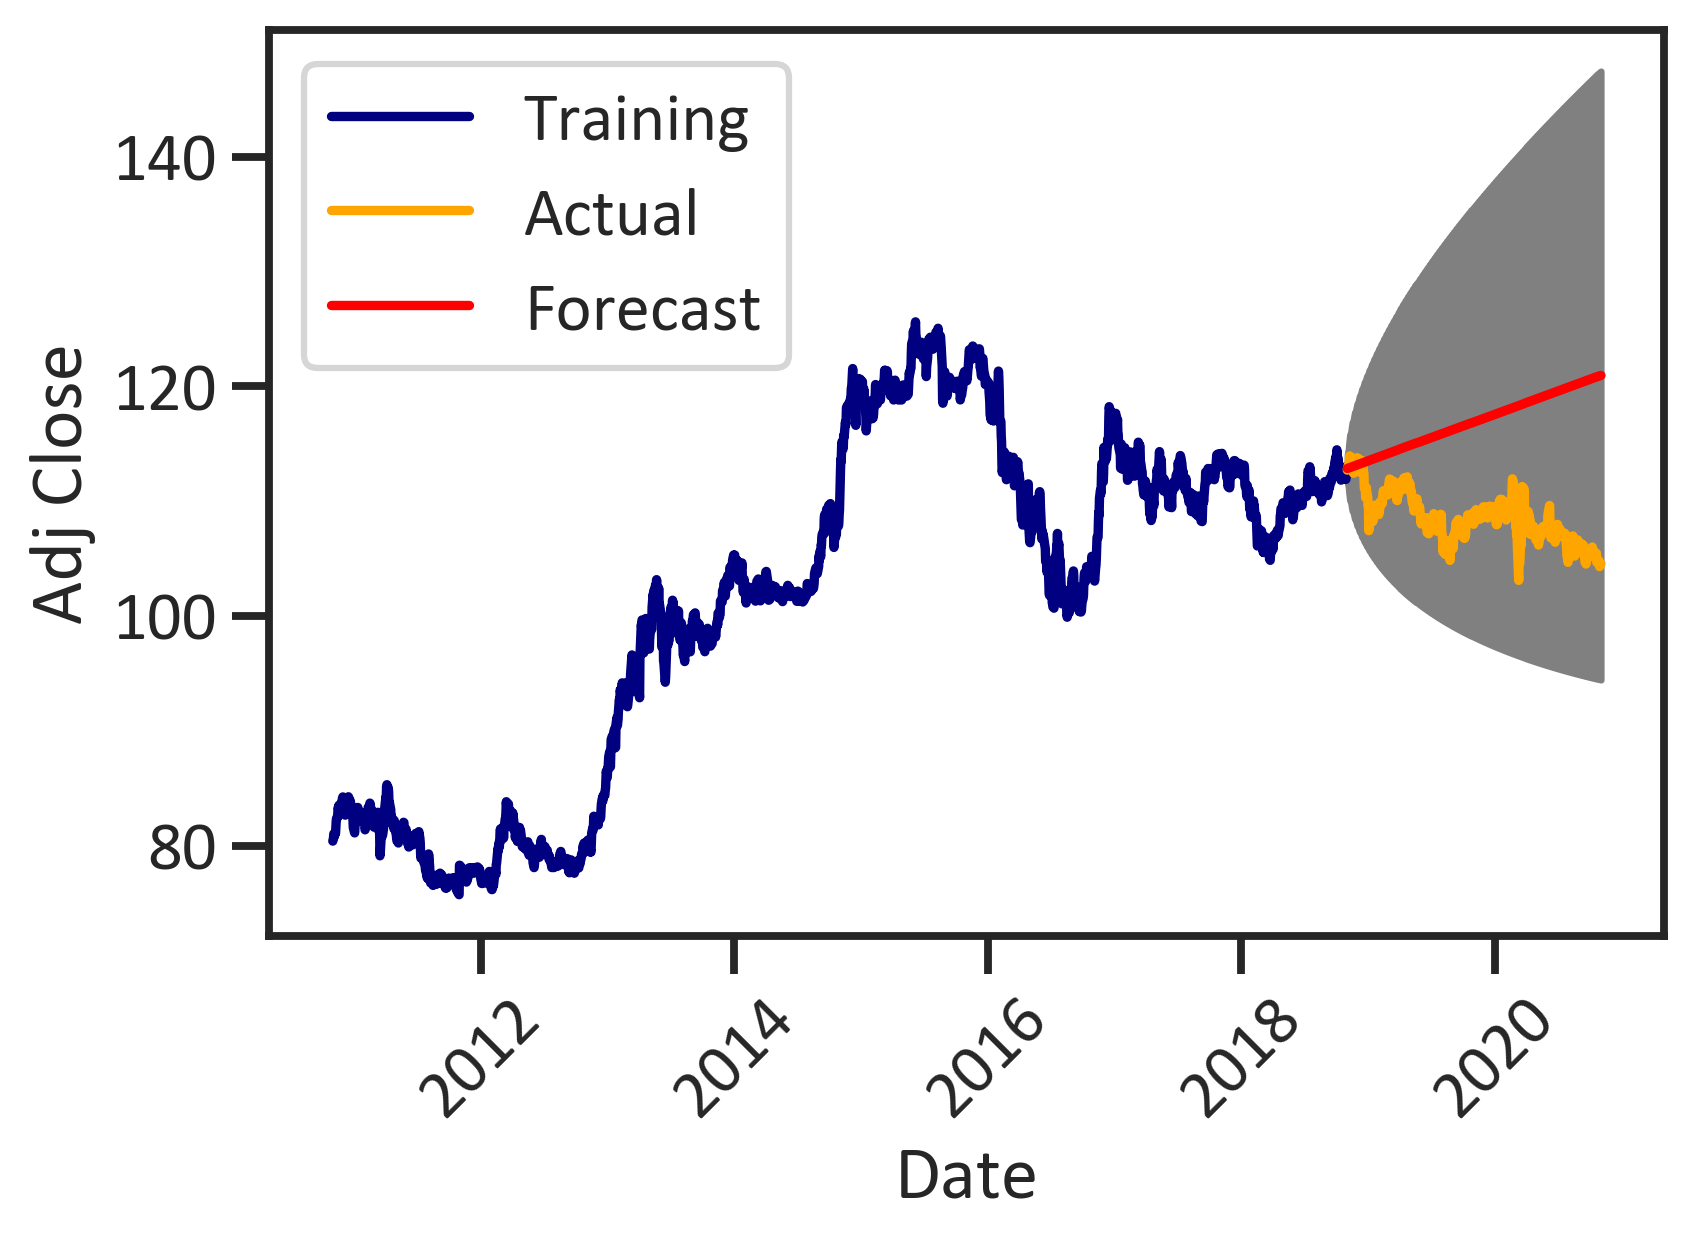

In [15]:
fc, se, conf = arima_fitted.forecast(521, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.plot(train, label="Training",color="navy")
plt.plot(test, label="Actual",color="orange")
plt.plot(fc_series, label="Forecast",color="red")
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series, 
                 color='gray')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

## Develop SARIMA Model

In [16]:
import pmdarima as pm
sarimax_model = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2085
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1901.217
Date:                Sat, 14 Nov 2020   AIC                           3808.435
Time:                        02:27:42   BIC                           3825.361
Sample:                             0   HQIC                          3814.637
                               - 2085                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8645      0.083    -10.411      0.000      -1.027      -0.702
ma.L1          0.8344      0.090      9.258      0.000       0.658       1.011
sigma2         0.3630      0.007     52.339      0.000       0.349       0.377
===================================================================================
Ljung-Box (Q):                       58.77   Jarque-Bera (JB):               955.16
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

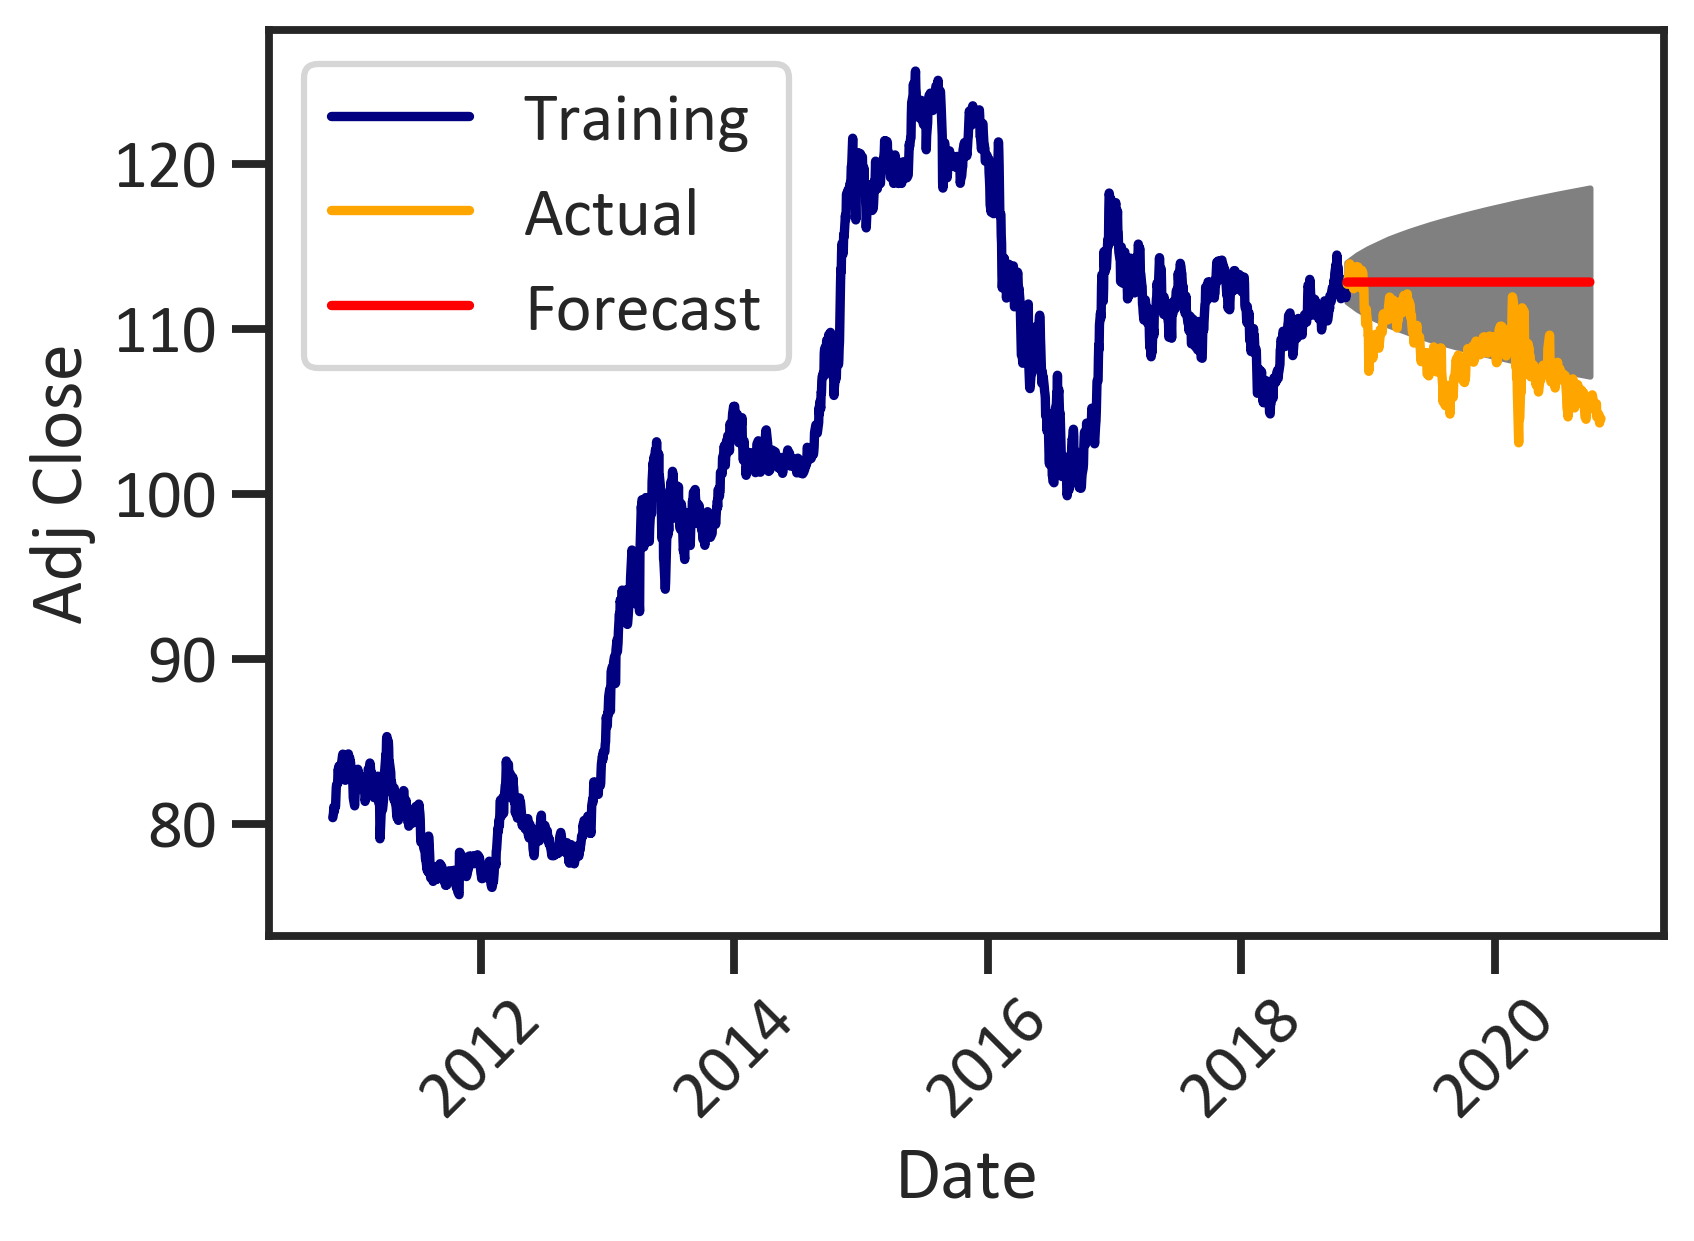

In [17]:
n_periods = 24
fitted, confint = sarimax_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
plt.plot(train, label="Training",color="navy")
plt.plot(test, label="Actual",color="orange")
plt.plot(fitted_series, label="Forecast",color="red")
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series, 
                 color='gray')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

In [18]:
df.head()

,Adj Close
Date,
2010-11-01,80.405998
2010-11-02,80.558998
2010-11-03,80.667999
2010-11-04,81.050003
2010-11-05,80.776001


# Develop Additive Model using Prophet

In [19]:
df = df.reset_index()
df["ds"] = df["Date"]
df["y"] = df["Adj Close"]
df.set_index("Date")

,Adj Close,ds,y
Date,,,
2010-11-01,80.405998,2010-11-01,80.405998
2010-11-02,80.558998,2010-11-02,80.558998
2010-11-03,80.667999,2010-11-03,80.667999
2010-11-04,81.050003,2010-11-04,81.050003
2010-11-05,80.776001,2010-11-05,80.776001
...,...,...,...
2020-10-27,104.832001,2020-10-27,104.832001
2020-10-28,104.544998,2020-10-28,104.544998
2020-10-29,104.315002,2020-10-29,104.315002


In [20]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95,
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True,
                changepoint_prior_scale=0.095)

In [21]:
model.fit(df)

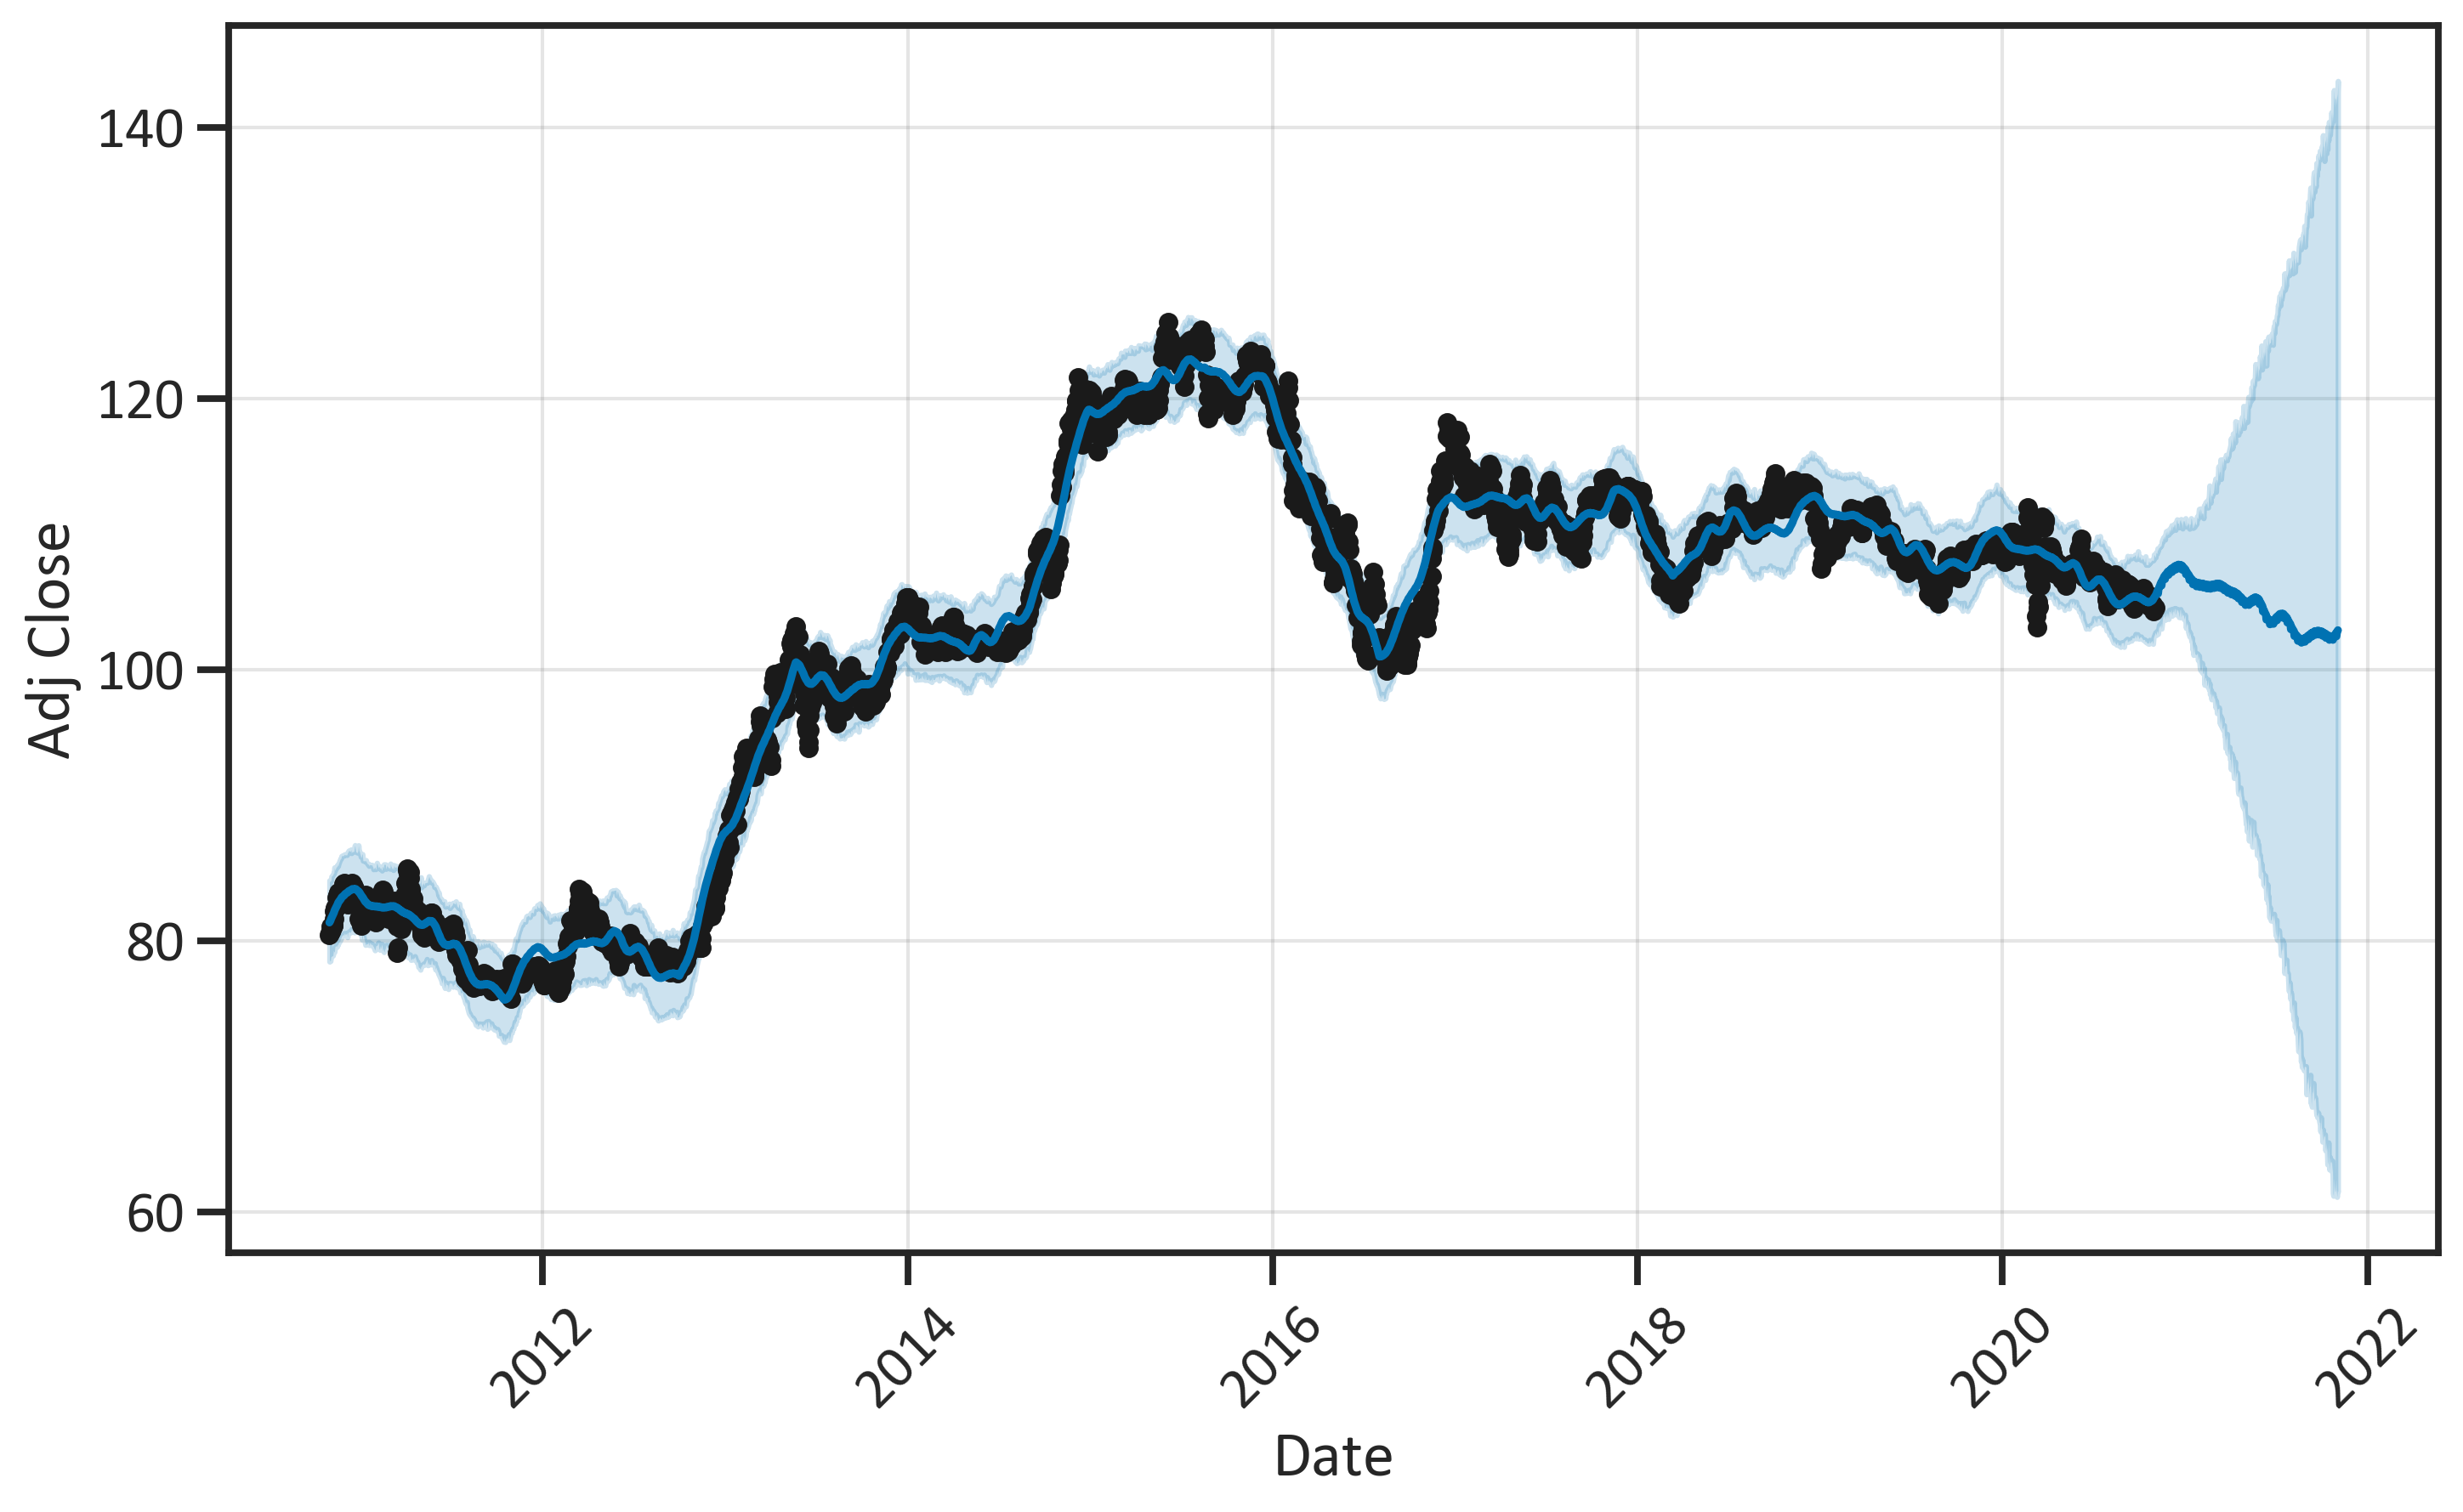

In [22]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.xticks(rotation=45)
plt.show()

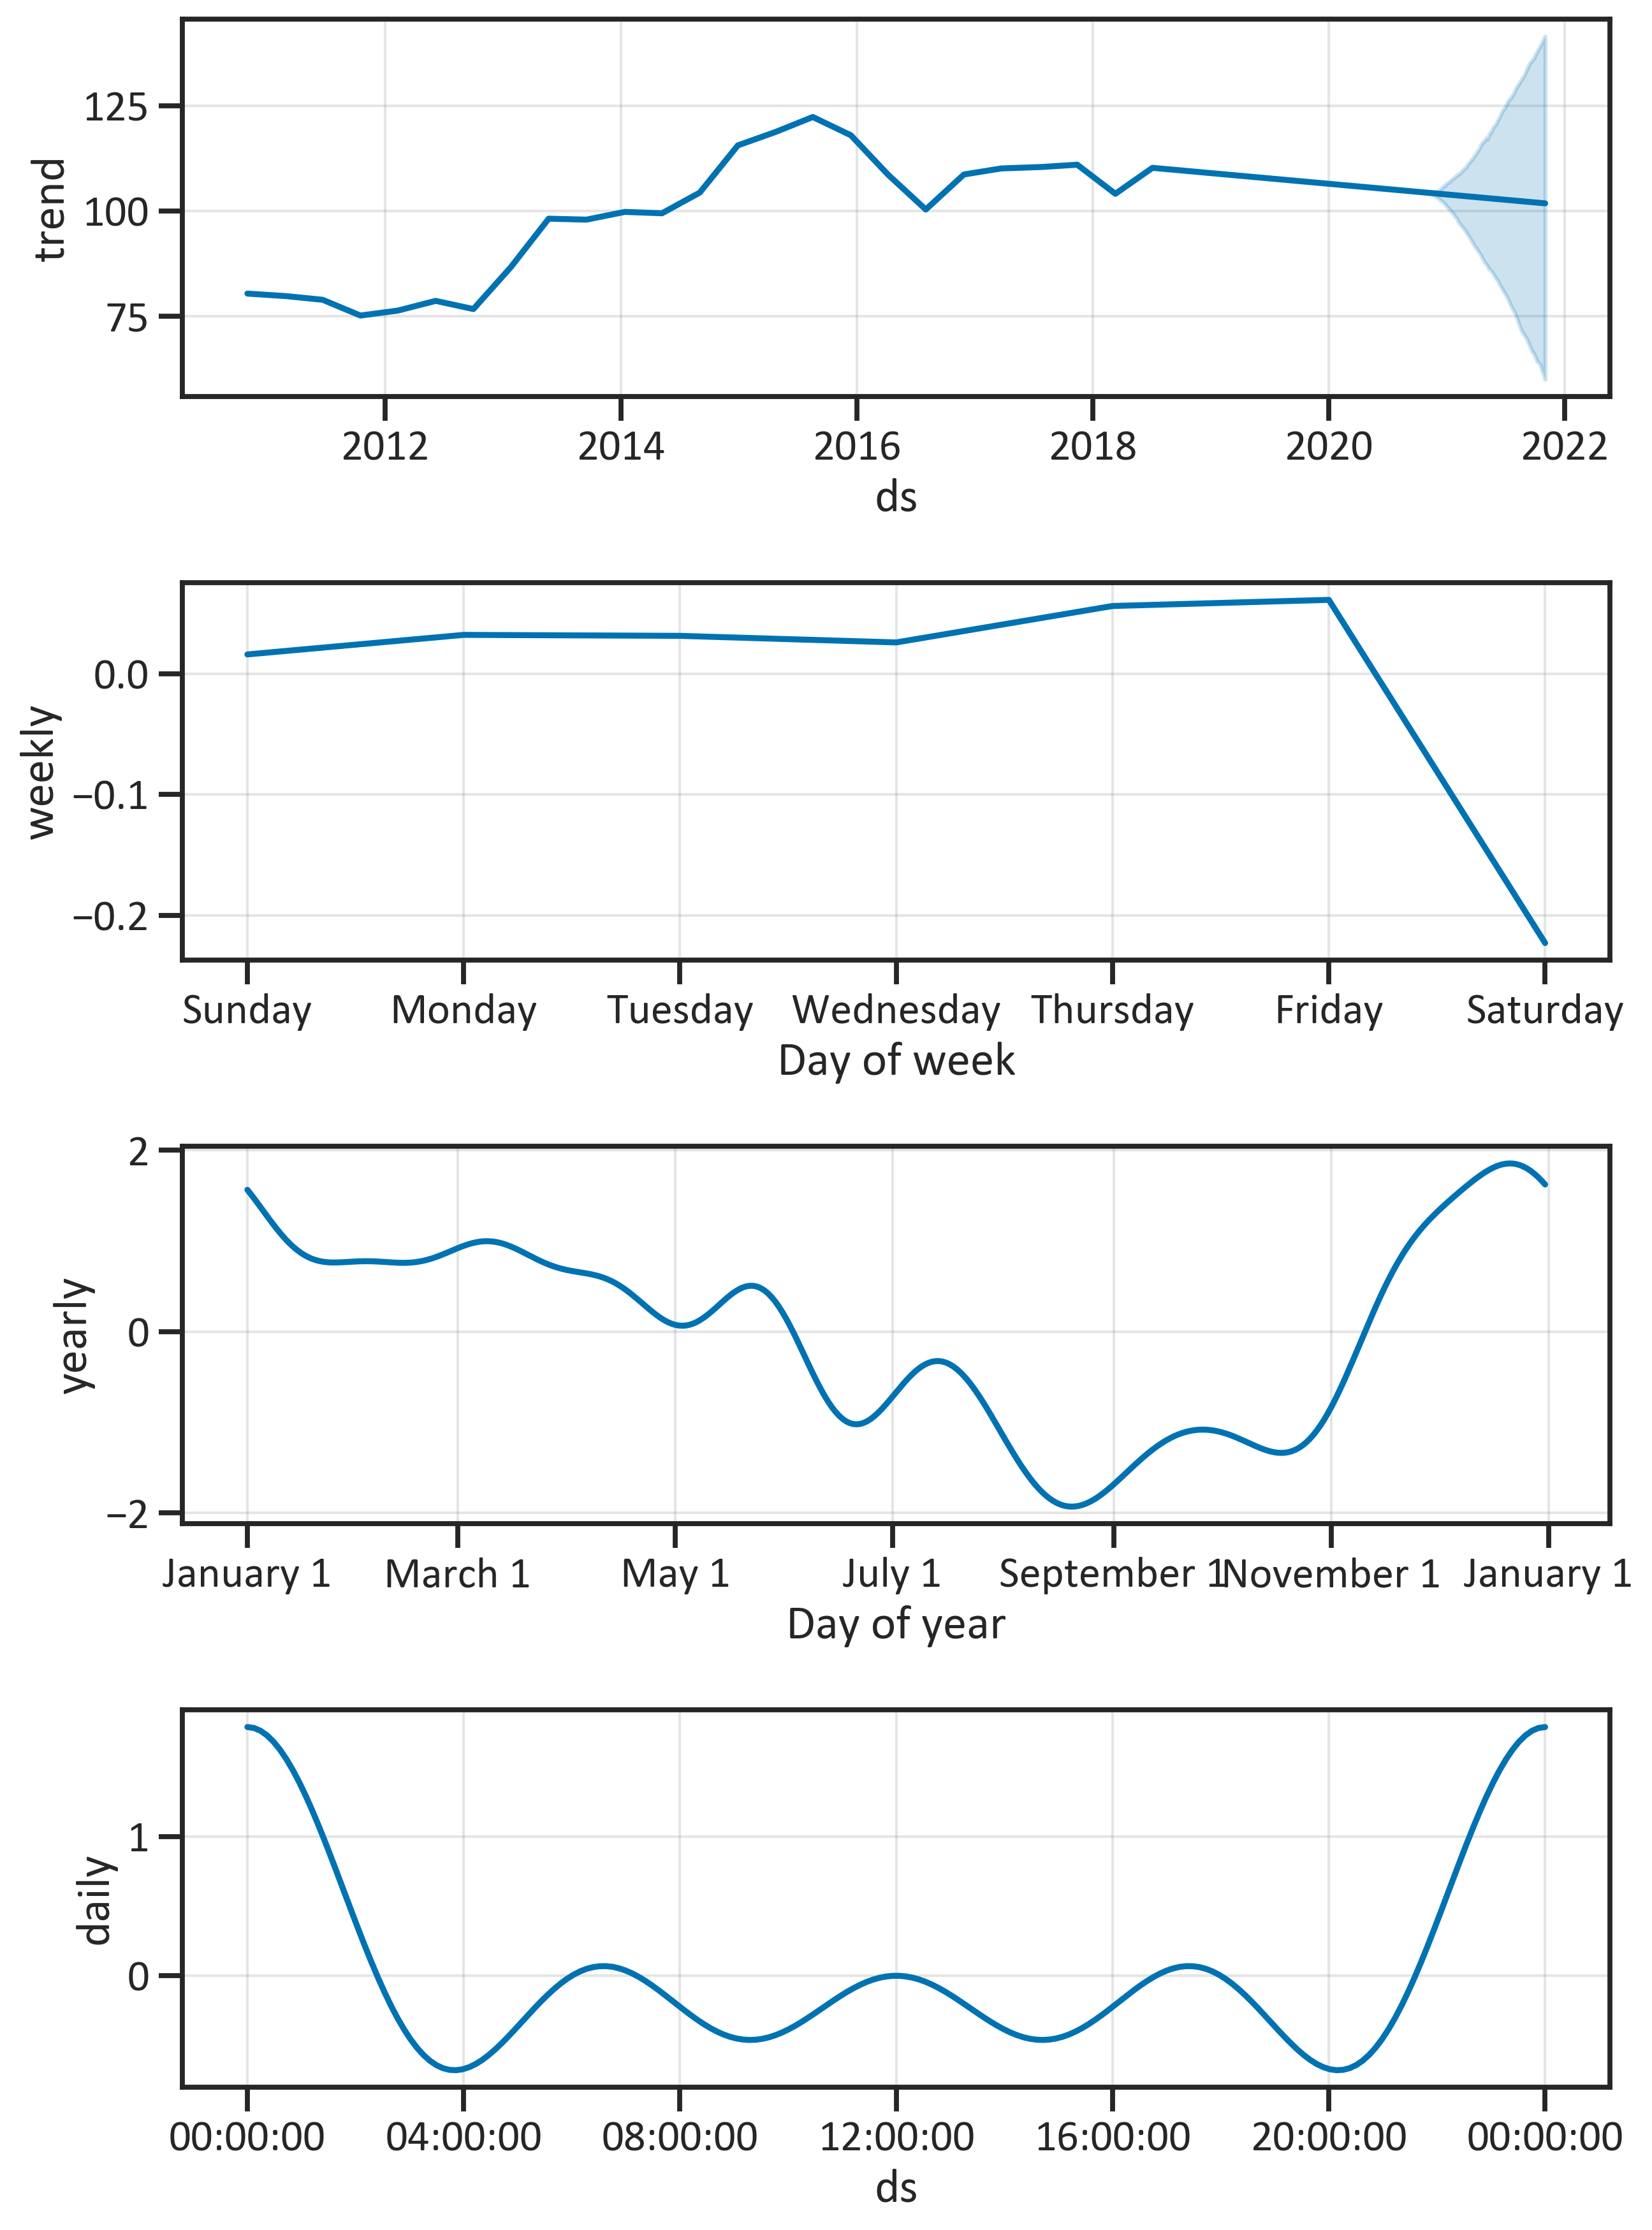

In [23]:
model.plot_components(forecast)
plt.show()